# T-SNE

- [1] Supervised t-SNE for Metric Learning With Stochastic and Geodesic Distances (https://ieeexplore.ieee.org/document/10734850)
- [2] t-viSNE: Interactive Assessment and Interpretation of t-SNE Projections (https://ieeexplore.ieee.org/document/9064929)

[1] A. Cervati Neto, A. L. M. Levada and M. Ferreira Cardia Haddad, "Supervised t-SNE for Metric Learning With Stochastic and Geodesic Distances," in IEEE Canadian Journal of Electrical and Computer Engineering, vol. 47, no. 4, pp. 199-205, Fall 2024, doi: 10.1109/ICJECE.2024.3429273. keywords: {Measurement;Stochastic processes;Euclidean distance;Classification algorithms;Vectors;Standards;Level measurement;Q measurement;Probability distribution;Minimization;Dimensionality reduction;geodesic distances;metric learning;stochastic distances;supervised classification;t-distributed stochastic neighbor embedding (t-SNE)},

[2] A. Chatzimparmpas, R. M. Martins and A. Kerren, "t-viSNE: Interactive Assessment and Interpretation of t-SNE Projections," in IEEE Transactions on Visualization and Computer Graphics, vol. 26, no. 8, pp. 2696-2714, 1 Aug. 2020, doi: 10.1109/TVCG.2020.2986996. keywords: {Tools;Visualization;Data visualization;Task analysis;Correlation;Principal component analysis;Dimensionality reduction;Interpretable t-SNE;dimensionality reduction;high-dimensional data;explainable machine learning;visualization},

In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

###########################################################
# Load Classifier and Data
###########################################################
pipeline = joblib.load('pipeline_classifier.pkl')
training_data = pd.read_csv("dataset/data_train.csv")
validation_data = pd.read_csv("dataset/data_validation.csv")

# Map labels to numerical values for binary classification
y_train = training_data['SOURCE'].map({'out': 0, 'in': 1})
X_train = training_data.drop(columns=['SOURCE'])
validation_data['SOURCE'] = validation_data['SOURCE'].map({'out': 0, 'in': 1})

###########################################################
# Preprocessing /  Predict
###########################################################
# Preprocess training data
X_train_preprocessed = pipeline.named_steps['preprocessor'].transform(X_train)

validation_data_features = validation_data.drop(columns=['SOURCE'])
validation_data_preprocessed = pipeline.named_steps['preprocessor'].transform(validation_data_features)


validation_predictions = pipeline.named_steps['classifier'].predict(validation_data_preprocessed)
true_labels = validation_data['SOURCE'].values
is_correct = validation_predictions == true_labels

results_df = pd.DataFrame({
    'true_label': true_labels,
    'predicted_label': validation_predictions,
    'is_correct': is_correct
})

In [2]:
###########################################################
# t-SNE
###########################################################

# Combine training and validation
combined_data = np.vstack((X_train_preprocessed, validation_data_preprocessed))

# t-sne
tsne_combined = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_combined_data = tsne_combined.fit_transform(combined_data)

# Split
reduced_training_data = reduced_combined_data[:len(X_train_preprocessed)]
reduced_validation_data = reduced_combined_data[len(X_train_preprocessed):]

# Add t-SNE results to results_df
results_df['TSNE1'] = reduced_validation_data[:, 0]
results_df['TSNE2'] = reduced_validation_data[:, 1]

# Create training_df for visualization
training_df = pd.DataFrame(reduced_training_data, columns=['TSNE1', 'TSNE2'])
training_df['true_label'] = y_train

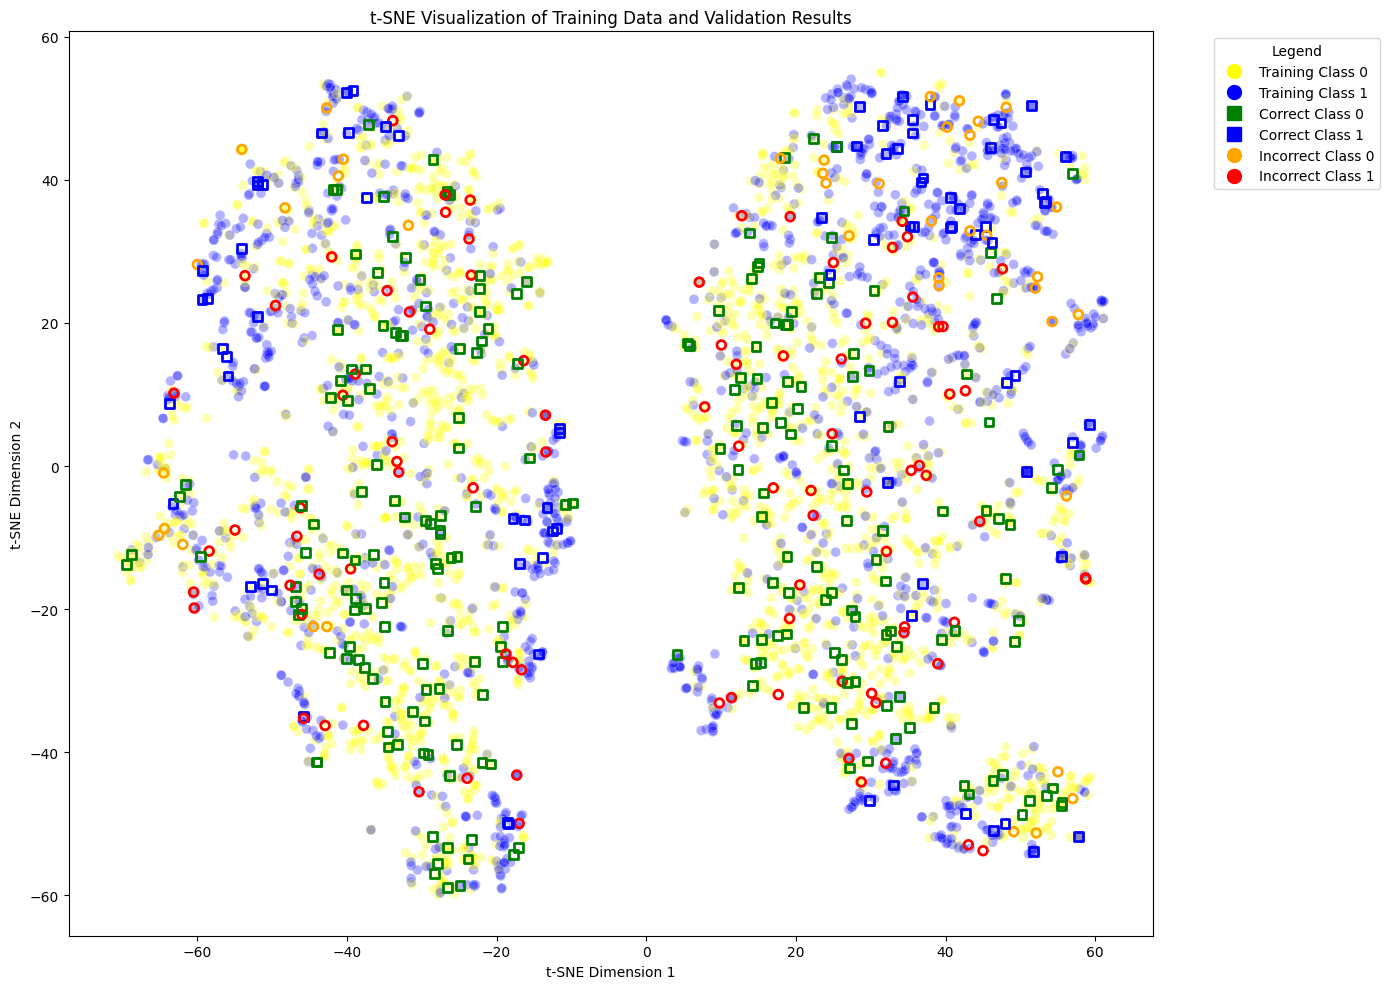

In [3]:
###########################################################
# Visualization
###########################################################
training_colors = {0: 'yellow', 1: 'blue'}
correct_colors = {0: 'green', 1: 'blue'}
incorrect_colors = {0: 'orange', 1: 'red'}

# Plot training
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=training_df,
    x='TSNE1',
    y='TSNE2',
    hue='true_label',
    palette=training_colors,
    alpha=0.3,  # Transparency
    s=50,
    legend=False
)

# Validation
for _, row in results_df.iterrows():
    if row['is_correct']:
        plt.scatter(
            row['TSNE1'], row['TSNE2'],
            facecolors='none',  # No fill color
            edgecolors=correct_colors[row['true_label']],  # Class-specific border color
            marker='s',  # Square for correct predictions
            s=40,
            linewidth=2
        )
    else:
        # incorrect predictions (circles)
        plt.scatter(
            row['TSNE1'], row['TSNE2'],
            facecolors='none',
            edgecolors=incorrect_colors[row['true_label']],
            marker='o',
            s=40,
            linewidth=2
        )

plt.title("t-SNE Visualization of Training Data and Validation Results")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='yellow', label='Training Class 0', markersize=10, linestyle=''),
        plt.Line2D([0], [0], marker='o', color='blue', label='Training Class 1', markersize=10, linestyle=''),
        plt.Line2D([0], [0], marker='s', color='green', label='Correct Class 0', markersize=10, linestyle=''),
        plt.Line2D([0], [0], marker='s', color='blue', label='Correct Class 1', markersize=10, linestyle=''),
        plt.Line2D([0], [0], marker='o', color='orange', label='Incorrect Class 0', markersize=10, linestyle=''),
        plt.Line2D([0], [0], marker='o', color='red', label='Incorrect Class 1', markersize=10, linestyle=''),
    ],
    bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend"
)
plt.tight_layout()
plt.show()